In [1]:
%load_ext autoreload

## Import modules

In [27]:
import itertools
import inspect
import copy
import statistics
from operator import itemgetter
from pathlib import Path
from typing import Callable, Optional, Iterable, Any

import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from qnet.model import Model

from workshop.common import CarUnit
from workshop.model import CarUnitModelMetrics
from main import Metrics, get_simulation_model, collect_metrics_over_simulation, run_simulation

### Config

In [3]:
target_metric_name = 'model__repair_wait_time_mean'

parallel_kwargs = dict(n_jobs=-1, backend='multiprocessing')

## Simulation time

### Config

In [4]:
save_path = Path('../../../coursework/')
collect_step_time = 1_000
num_runs = 20
simulation_time = 150_000
end_time = 200_000

### Collect metrics

In [7]:
runs_metrics = Parallel(**parallel_kwargs)(
    delayed(collect_metrics_over_simulation)(model=get_simulation_model(first_repair_priority=False).dumps(),
                                             start_time=0,
                                             end_time=end_time,
                                             collect_step_time=collect_step_time) for _ in range(num_runs))

### Analysis

[Text(0.5, 0, 'Simulation time'),
 Text(0, 0.5, 'Total wait time before repairs')]

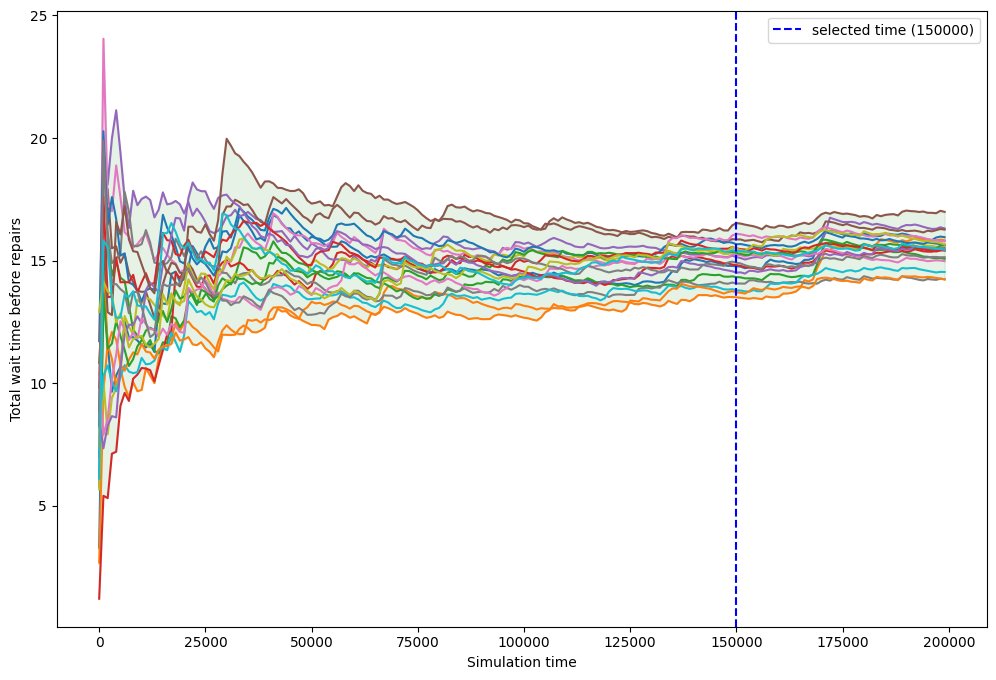

In [8]:
time_steps = np.arange(0, end_time, collect_step_time)
runs_target_metric = np.asarray(list(map(itemgetter(target_metric_name),
                                         itertools.chain.from_iterable(runs_metrics)))).reshape(num_runs, -1)

fig, ax = plt.subplots(figsize=(12, 8))

ax.fill_between(time_steps, runs_target_metric.min(axis=0), runs_target_metric.max(axis=0), color='green', alpha=0.1)
for idx in range(num_runs):
    ax.plot(time_steps, runs_target_metric[idx])
ax.axvline(simulation_time, linestyle='--', color='blue', label=f'selected time ({simulation_time})')

ax.legend(loc='upper right')
ax.set(xlabel='Simulation time', ylabel='Total wait time before repairs')
# fig.savefig(save_path.joinpath('simulation_time_2.png'), dpi=300)

## Analysis of variance

### Config

In [9]:
alpha = 0.05

### Collect metrics

In [10]:
first_metrics = Parallel(**parallel_kwargs)(delayed(run_simulation)(
    model=get_simulation_model(first_repair_priority=True).dumps(), simulation_time=simulation_time)
                                            for _ in range(num_runs))

second_metrics = Parallel(**parallel_kwargs)(delayed(run_simulation)(
    model=get_simulation_model(first_repair_priority=False).dumps(), simulation_time=simulation_time)
                                             for _ in range(num_runs))

### Analysis

In [11]:
metrics = np.asarray(list(map(itemgetter(target_metric_name), itertools.chain(first_metrics,
                                                                              second_metrics)))).reshape(2, -1)

In [12]:
num_factors, num_runs = metrics.shape
rest_deg = num_factors - 1
factor_deg = num_factors * (num_runs - 1)
factors_means = metrics.mean(axis=1, keepdims=True)
mean = factors_means.mean()
d_rest = num_runs * np.square(factors_means - mean).mean() / rest_deg
d_factor = np.square(metrics - factors_means).sum() / factor_deg
f_exp = d_rest / d_factor
f_critical = scipy.stats.f.ppf(1 - alpha, rest_deg, factor_deg)

In [13]:
print(f'''
Rest degrees of freedom: {rest_deg}
Factor degrees of freedom: {factor_deg}
Mean: {mean:.3f}
Factors means: {factors_means[0, 0]:.3f} and {factors_means[1, 0]:.3f}
F experimental: {f_exp:.3f}
F critical: {f_critical:.3f}
Factors have {'negligible' if f_exp < f_critical else 'significant'} effect
''')


Rest degrees of freedom: 1
Factor degrees of freedom: 38
Mean: 14.666
Factors means: 14.424 and 14.908
F experimental: 2.285
F critical: 4.098
Factors have negligible effect



## Model verification

### Config

In [5]:
runs_params = [
    {},
    {
        'factory_delay_mean': 20.5
    },
    {
        'repair_delay_mean': 11.0
    },
    {
        'repair_delay_var': 121.0
    },
    {
        'repair_max_channels': 6
    },
    {
        'control_delay': 3.0
    },
    {
        'control_max_channels': 2
    },
    {
        'revision_proba': 0.3
    },
]
first_params = {'first_repair_priority': True}
second_params = {'first_repair_priority': False}

### Utils

In [70]:
MetricsPostprocessor = Callable[[Metrics], Metrics]


def grouper(values: Iterable[Any], count: int) -> Iterable[Iterable[Any]]:
    iter_groups = [iter(values)] * count
    return zip(*iter_groups)


def get_verification_table(runs_params: list[dict[str, Any]],
                           extra_params: dict[str, Any],
                           simulation_time: float,
                           num_runs: int,
                           metrics_postprocessor: Optional[MetricsPostprocessor] = None) -> pd.DataFrame:

    defaults = {name: value.default for name, value in inspect.signature(get_simulation_model).parameters.items()}
    defaults.update(extra_params)
    runs_params = [defaults | run_params for run_params in runs_params]

    runs_metrics = Parallel(**parallel_kwargs)(delayed(run_simulation)(
        model=get_simulation_model(**run_params).dumps(),
        simulation_time=simulation_time,
    ) for run_params in runs_params for _ in range(num_runs))

    if metrics_postprocessor:
        runs_metrics = map(metrics_postprocessor, runs_metrics)

    verification_table = copy.deepcopy(runs_params)
    for group_metrics, row in zip(grouper(runs_metrics, count=num_runs), verification_table):
        for run_metrics in group_metrics:
            for metric_name, value in run_metrics.items():
                try:
                    mean_value = value / num_runs
                    row[metric_name] = row[metric_name] + mean_value if metric_name in row else mean_value
                except TypeError:
                    continue

    column_names: list[tuple[str, str]] = []
    for param_name in verification_table[0]:
        try:
            base_name, name = param_name.split('__')
        except ValueError:
            base_name, name = 'input', param_name
        column_names.append((base_name, name))

    multi_index = pd.MultiIndex.from_tuples(column_names)
    return pd.DataFrame([row.values() for row in verification_table], columns=multi_index)

### Verification

In [71]:
first_table = get_verification_table(runs_params=runs_params,
                                     extra_params=first_params,
                                     simulation_time=simulation_time,
                                     num_runs=1)

second_table = get_verification_table(runs_params=runs_params,
                                      extra_params=second_params,
                                      simulation_time=simulation_time,
                                      num_runs=4)

In [23]:
first_table.transpose()
# first_table.transpose().to_excel(save_path.joinpath('verification_1.xlsx'))

0          1  \
input                    factory_delay_mean         10.25       20.5   
                         first_repair_priority       True       True   
                         repair_delay_mean           22.0       22.0   
                         repair_delay_var           242.0      242.0   
                         repair_max_channels            3          3   
                         control_delay                6.0        6.0   
                         control_max_channels           1          1   
                         revision_proba              0.15       0.15   
model                    mean_event_intensity     0.32248   0.159595   
                         mean_time_in_system    53.508855  40.875791   
                         num_repairs_mean        1.152443   1.154091   
                         num_repairs_std         0.368585   0.371684   
                         repair_wait_time_mean  16.101986   1.565625   
                         repair_wait_time_std    43.00254    5.66353   
                         num_events               48372.0   23939.25   
evaluation               mean_units_in_system    5.165397   1.708128   
1_car_unit_factory       num_in                       0.0        0.0   
                         num_out                 14638.25     7236.5   
2_repair_shop            failure_proba                0.0        0.0   
                         mean_channels_load      2.484335    1.22368   
                         mean_in_interval        8.891546  17.960863   
                         mean_load_time         22.093385  21.978483   
                         mean_out_interval        8.89294  17.961538   
                         mean_queuelen           1.573768   0.075526   
                         mean_wait_time         13.995538   1.356412   
                         num_in                   16870.0    8351.75   
                         num_out                  16867.0     8351.5   
3_control_shop           failure_proba                0.0        0.0   
                         mean_channels_load      0.674672   0.334054   
                         mean_in_interval         8.89294  17.961538   
                         mean_load_time          6.000013   6.000065   
                         mean_out_interval       8.893091  17.961271   
                         mean_queuelen           0.432623   0.074868   
                         mean_wait_time          3.847517   1.344681   
                         num_in                   16867.0     8351.5   
                         num_out                 16866.75    8351.25   
4_repair_shop_vs_release num_in                  16866.75    8351.25   
                         num_out                 16866.75    8351.25   

                                                       2          3  \
input                    factory_delay_mean        10.25      10.25   
                         first_repair_priority      True       True   
                         repair_delay_mean          11.0       22.0   
                         repair_delay_var          242.0      121.0   
                         repair_max_channels           3          3   
                         control_delay               6.0        6.0   
                         control_max_channels          1          1   
                         revision_proba             0.15       0.15   
model                    mean_event_intensity   0.322423    0.32275   
                         mean_time_in_system    18.39432  51.483186   
                         num_repairs_mean       1.151734   1.153455   
                         num_repairs_std        0.368676   0.369026   
                         repair_wait_time_mean       0.0  15.307662   
                         repair_wait_time_std        0.0  42.082729   
                         num_events              48363.5    48412.5   
evaluation               mean_units_in_system    1.45613   4.976747   
1_car_unit_factory       num_in         

In [21]:
second_table.transpose()
# second_table.transpose().to_excel(save_path.joinpath('verification_2.xlsx'))

0          1  \
input                    factory_delay_mean         10.25       20.5   
                         first_repair_priority      False      False   
                         repair_delay_mean           22.0       22.0   
                         repair_delay_var           242.0      242.0   
                         repair_max_channels            3          3   
                         control_delay                6.0        6.0   
                         control_max_channels           1          1   
                         revision_proba              0.15       0.15   
model                    mean_event_intensity    0.323285   0.159973   
                         mean_time_in_system    53.981607  40.855114   
                         num_repairs_mean        1.156423   1.155295   
                         num_repairs_std         0.372266   0.371517   
                         repair_wait_time_mean  16.462747   1.618732   
                         repair_wait_time_std   42.411086    5.71823   
                         num_events              48492.75    23996.0   
evaluation               mean_units_in_system    5.217373   1.712022   
1_car_unit_factory       num_in                       0.0        0.0   
                         num_out                 14641.75     7249.0   
2_repair_shop            failure_proba                0.0        0.0   
                         mean_channels_load      2.481624   1.224989   
                         mean_in_interval        8.858873  17.911269   
                         mean_load_time         21.992442  21.944045   
                         mean_out_interval       8.862236  17.913707   
                         mean_queuelen           1.611586   0.078244   
                         mean_wait_time         14.282148   1.401706   
                         num_in                  16931.75     8375.0   
                         num_out                  16926.0     8373.5   
3_control_shop           failure_proba                0.0        0.0   
                         mean_channels_load      0.677015    0.33494   
                         mean_in_interval        8.862236  17.913707   
                         mean_load_time          6.000129        6.0   
                         mean_out_interval       8.862558  17.913828   
                         mean_queuelen           0.447148    0.07385   
                         mean_wait_time          3.962944   1.322956   
                         num_in                   16926.0     8373.5   
                         num_out                  16925.0     8373.5   
4_repair_shop_vs_release num_in                   16925.0     8373.5   
                         num_out                  16925.0     8373.5   

                                                        2          3  \
input                    factory_delay_mean         10.25      10.25   
                         first_repair_priority      False      False   
                         repair_delay_mean           11.0       22.0   
                         repair_delay_var           242.0      121.0   
                         repair_max_channels            3          3   
                         control_delay                6.0        6.0   
                         control_max_channels           1          1   
                         revision_proba              0.15       0.15   
model                    mean_event_intensity    0.322515   0.322233   
                         mean_time_in_system    18.394822  51.740235   
                         num_repairs_mean        1.152035   1.151253   
                         num_repairs_std          0.36858   0.367351   
                         repair_wait_time_mean        0.0  15.605969   
                         repair_wait_time_std         0.0  39.955924   
                         num_events              48377.25    48335.0   
evaluation               mean_units_in_system    1.456774   5.002574   
1_car_unit_factory     